# Sea ice and meridional heat transport climatology

In [1]:
import intake
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean as cm
import glob
import matplotlib.colors as col
import matplotlib.gridspec as gridspec
import cf_xarray as cf
# need to install opencv-python for this:
import cv2
import warnings
import logging
from scipy.ndimage import distance_transform_edt
import scipy.ndimage as nd
from scipy.interpolate import griddata
from matplotlib.animation import FuncAnimation
import imageio.v3 as iio
import glob
import imageio.v3 as iio
import cmocean.cm as cm

logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client


In [2]:
client = Client(threads_per_worker = 1)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that i

In [3]:
#in this definition, no frequency can be used only for static data
iaf_run = '01deg_jra55v140_iaf_cycle3'
catalog = intake.cat.access_nri
#defining importing function
def importer(experiment,catalog,variable, frequency = 'fx',start_time=0,end_time=0):
    warnings.filterwarnings('ignore')
    var = catalog[experiment].search(variable=variable, frequency = frequency).to_dask(xarray_open_kwargs={'decode_timedelta':True})
    if start_time!=0:
        time_slice='slice(start_time,end_time)'
        return eval("var." + variable + ".sel(time=" + time_slice + ")")
    elif start_time ==0:
        return eval("var." + variable)

# defining list variables function
def intakelist(catalog,experiment):
    return catalog[experiment].unique().variable

## I - Calculating climatologies

Climatologies will be calculated once and saved into a netcdf file, which means we only need to run ths section *I* of the code, **once**

Calculating sea ice extent climatology

In [4]:
#### This cells takes a HUGE TIME to run
#importing area
area_icemodel = importer(iaf_run,catalog,variable='tarea', frequency = '1mon').isel(nj=slice(1,800)).compute()
#importing sea ice fraction
SIF = importer(iaf_run,catalog,variable='aice_m', frequency = '1mon').isel(nj=slice(1,800))
#setting SIF limit for SIE
SIF_limit = 0.15 #limit of fraction below which we consider the cell ice free for ice extent calculations
#filtering out ice-free cells in SIF
SIF_forextent = SIF.where(SIF >SIF_limit)
#calcualting sea ice extent
SIE = (SIF_forextent * area_icemodel).sum(('nj','ni'))
#calculating monthly climatology
SIE_clim = SIE.groupby('time.month').mean().compute()

calculating sea ice area

In [5]:
# monthly sea ice area
SIA = (SIF * area_icemodel).sum(('nj','ni'))
#calculating monthly climatology
SIA_clim = SIA.groupby('time.month').mean().compute()

calculating climatology of zonal means of meridional heat transport

In [6]:
lat_slice=slice(-90,-45)
#importing sea ice fraction
Ty = importer(iaf_run,catalog,variable='temp_yflux_adv', frequency = '1mon').sel(yu_ocean=lat_slice)
#calculating zonal sum
Ty_ZM =Ty.sum('xt_ocean')
#calculating climatology of full data and zonal means
Tyfull_clim = Ty.groupby('time.month').mean().compute()
TyZM_clim = Ty_ZM.groupby('time.month').mean().compute()

In [7]:
# saving sea ice values and variables
savedir = '/g/data/ik11/users/wf4500/OM2_Eddies_SeaIce/Plotted_data/'

#sea ice extent and area
SIE_clim.name = 'SIE_m2'
SIA_clim.name = 'SIA_m2'
SIA.name = 'SIA_m2'
SIE_clim.to_netcdf(savedir+'SIE_climatology_OM2_IAF.nc')
SIA_clim.to_netcdf(savedir+'SIA_climatology_OM2_IAF.nc')
SIA.to_netcdf(savedir+'SIA_monthly_OM2_IAF.nc')

# heat transports
TyZM_clim.name = 'MHT_xsum_watts'
Tyfull_clim.name = 'MHT_watts'
Tyfull_clim.to_netcdf(savedir+'MHT_climatology_OM2_IAF.nc')
TyZM_clim.to_netcdf(savedir+'MHT_ZM_climatology_OM2_IAF.nc')

## II - Plotting climatology of heat transports and sea ice

Importing climatologies again

In [8]:
savedir = '/g/data/ik11/users/wf4500/OM2_Eddies_SeaIce/Plotted_data/'

#sea ice
SIE_clim = xr.open_dataset(savedir+'SIE_climatology_OM2_IAF.nc')
SIA_clim = xr.open_dataset(savedir+'SIA_climatology_OM2_IAF.nc')
SIA = xr.open_dataset(savedir+'SIA_monthly_OM2_IAF.nc')
# heat transports

Tyfull_clim = xr.open_dataset(savedir+'MHT_climatology_OM2_IAF.nc')
TyZM_clim = xr.open_dataset(savedir+'MHT_ZM_climatology_OM2_IAF.nc')

calculating climatology from obs

In [14]:
def open_cdr_dataset(path, area_file):
    ds = xr.open_dataset(path).rename(
        {'cdr_seaice_conc_monthly': 'cdr_conc', 'xgrid':'x','ygrid':'y'}
    )

    # # we also need the area of each gridcell
    areasNd = np.fromfile(area_file, dtype=np.int32).reshape(
        ds.cdr_conc.isel(time=0).shape
    )
    # # Divide by 1000 to get km2 (https://web.archive.org/web/20170817210544/http://nsidc.org/data/polar-stereo/tools_geo_pixel.html#pixel_area)
    areasKmNd_sh = areasNd / 1000
        
    ds["area"] = xr.DataArray(areasKmNd_sh, dims=["y", "x"])
    ds = ds.set_coords("area")

    ds["cdr_conc"] = ds.cdr_conc.where(ds.cdr_conc<=1)  # convert error codes to Nan

    return ds

In [15]:
!wget --ftp-user=anonymous -nc ftp://sidads.colorado.edu/DATASETS/seaice/polar-stereo/tools/pss25area_v3.dat ftp://sidads.colorado.edu/DATASETS/seaice/polar-stereo/tools/psn25area_v3.dat

File ‘pss25area_v3.dat’ already there; not retrieving.
File ‘psn25area_v3.dat’ already there; not retrieving.


In [19]:
from xarray import DataTree, map_over_datasets
OBS_TIME_SLICE = slice("1979", "2022")
sh_obs_url = "https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4shmday"

In [20]:
sh_cdr_xr = open_cdr_dataset(sh_obs_url, "pss25area_v3.dat")

cdr_dt = DataTree.from_dict(
    {
        "cdr_sh": sh_cdr_xr,
    }
)

In [24]:
def sea_ice_area_obs(ds):

    # root dataset in datatree is not used
    if ds is None or 'time' not in ds:
        return ds
    
    sic = ds.cdr_conc
    result = sea_ice_area(sic, sic.area).to_dataset(name="cdr_area")

    # Theres a couple of data gaps which should be nan
    result.loc[{"time": "1988-01-01"}] = np.nan
    result.loc[{"time": "1987-12"}] = np.nan

    return result.sel(time=OBS_TIME_SLICE)

def sea_ice_area(sic, area, range=[0.15, 1]):
    return (sic * area).where((sic >= range[0]) * (sic <= range[1])).cf.sum(["X", "Y"])

obs_area_dt = cdr_dt.map_over_datasets(sea_ice_area_obs)

In [33]:
CLIMAT_TIME_SLICE = slice("1991", "2020")


def climatology(ds):
    return ds.sel(time=CLIMAT_TIME_SLICE).groupby("time.month").mean("time")

In [169]:
#integrating meridional heat transport in x and y direction to get only z
yslice = slice(-90,-50)# selecting only areas south of the tip of south america, where sea ice rarely exists
Tyfull_clim_Z = Tyfull_clim.MHT_watts.sel(yu_ocean=yslice).sum(('xt_ocean','yu_ocean')).compute()
#heat transport integrated vertically and zonally
Tyfull_clim_y = Tyfull_clim.MHT_watts.sum(('xt_ocean','st_ocean')).compute()
#heat transport integrated vertically and zonally, but only in the upper 500 m depth
Tyfull_clim_y_z500 = Tyfull_clim.MHT_watts.sel(st_ocean=slice(0,500)).sum(('xt_ocean','st_ocean')).compute()
#heat transport integrated vertically but only in the upper 500 m depth
Tyfull_clim_yx_z500 = Tyfull_clim.MHT_watts.sel(st_ocean=slice(0,500)).sum('st_ocean').compute()

In [174]:
figdir = '/g/data/ik11/users/wf4500/OM2_Eddies_SeaIce/figs/'

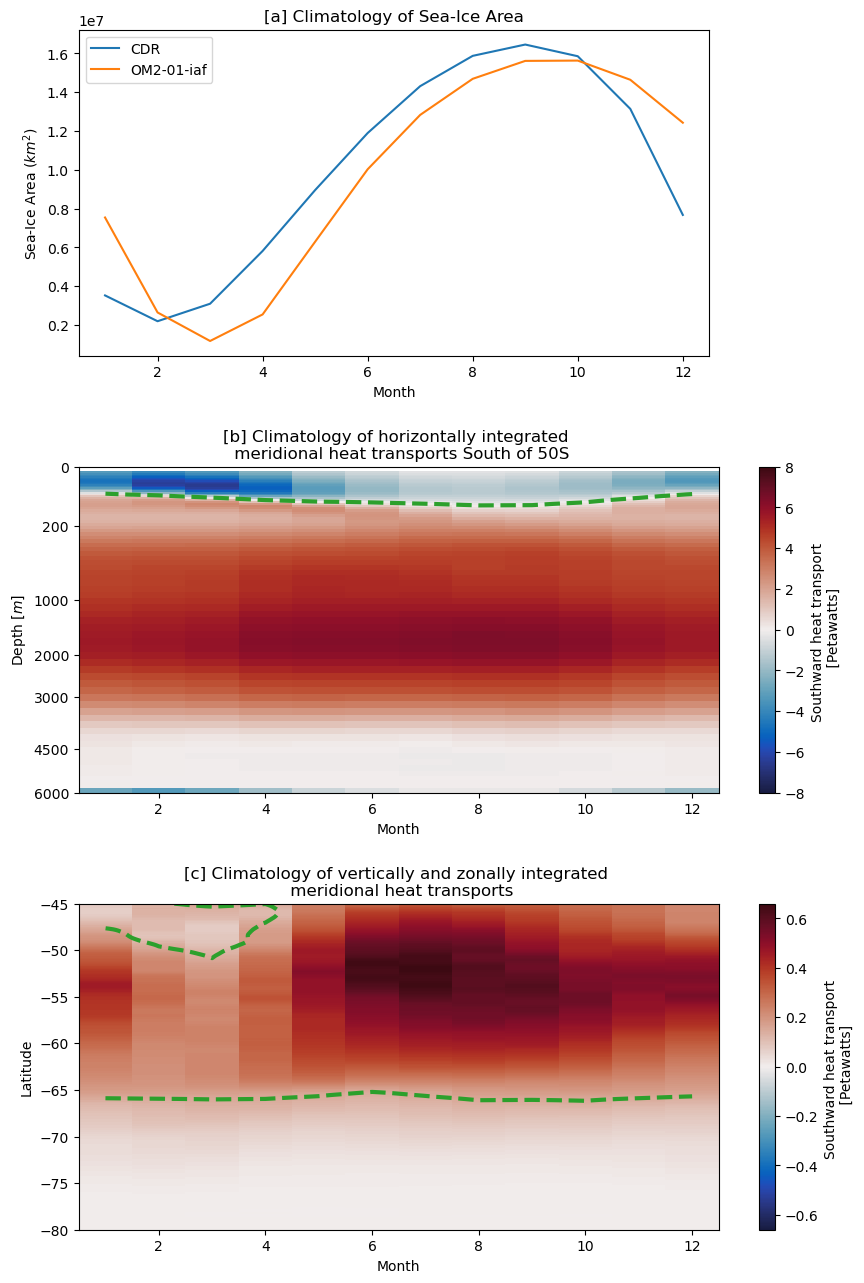

In [176]:
# Function x**(1/2)
def forward(x):
    return x**(1/2)


def inverse(x):
    return x**2

fig = plt.figure(figsize=(10,15))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.34)
gs = gridspec.GridSpec(3, 5, height_ratios=[1, 1, 1])


ax1 = fig.add_subplot(gs[0, 0:4])
climatology(obs_area_dt["cdr_sh"].ds.cdr_area).plot(label="CDR")
climatology(1e-6*SIA).plot(label="OM2-01-iaf")
plt.title("[a] Climatology of Sea-Ice Area")
plt.ylabel("Sea-Ice Area ($km^2$)")
plt.xlabel('Month')
plt.xlim(0.5,12.5)
plt.legend()


ax2 = fig.add_subplot(gs[1, :])
(-1e-15*Tyfull_clim_Z).plot(y='st_ocean',vmin=-8,vmax=8,cmap=cm.balance,cbar_kwargs={'label': "Southward heat transport \n [Petawatts]"})
(Tyfull_clim_Z.sel(st_ocean=slice(0,2000))).plot.contour(y='st_ocean',levels=[0,],linewidths=3,linestyles='--',colors='tab:green')
plt.ylim(6000,0)
ax2.set_yscale('function', functions=(forward, inverse))
plt.yticks(ticks=[0,200,1000,2000,3000,4500,6000])
plt.ylabel(r"Depth [$m$]")
plt.title("[b] Climatology of horizontally integrated \n meridional heat transports South of 50S")
plt.xlabel('Month')

ax3 = fig.add_subplot(gs[2, :])
(-1e-15*Tyfull_clim_y).plot(y='yu_ocean',cmap=cm.balance,cbar_kwargs={'label': "Southward heat transport \n [Petawatts]"})
(-1e-15*Tyfull_clim_y).plot.contour(y='yu_ocean',levels=[0.15,],linewidths=3,linestyles='--',colors='tab:green')
plt.ylim(-80,-45)
plt.ylabel('Latitude')
plt.xlabel('Month')
plt.title("[c] Climatology of vertically and zonally integrated \n meridional heat transports")

plt.savefig(figdir + 'Full_depth_seasonality.png',dpi=300)

There is some interesting seasonal cycle in the poleward heat transport. 

- Vertical cycle: As sea ice grows, the poleward heat transport intensifies in the depths of CDW (~2000 m). This coincides with a perriod where AABW northward heat transport (blue, ~6000m) decreases. At surface, the interface between northward and Southward heat transport deepens
- Meridional: The maximum meridional heat transport seem to be concentrated arouund 55 S, but sea ice cycles dont seem to change much how far south the vertically integrated meridional heat transport goes.


That basically means that as sea ice grows, heat transport concentrates heat at 2000m depth and around 55 S

### Sub-surface heat transports

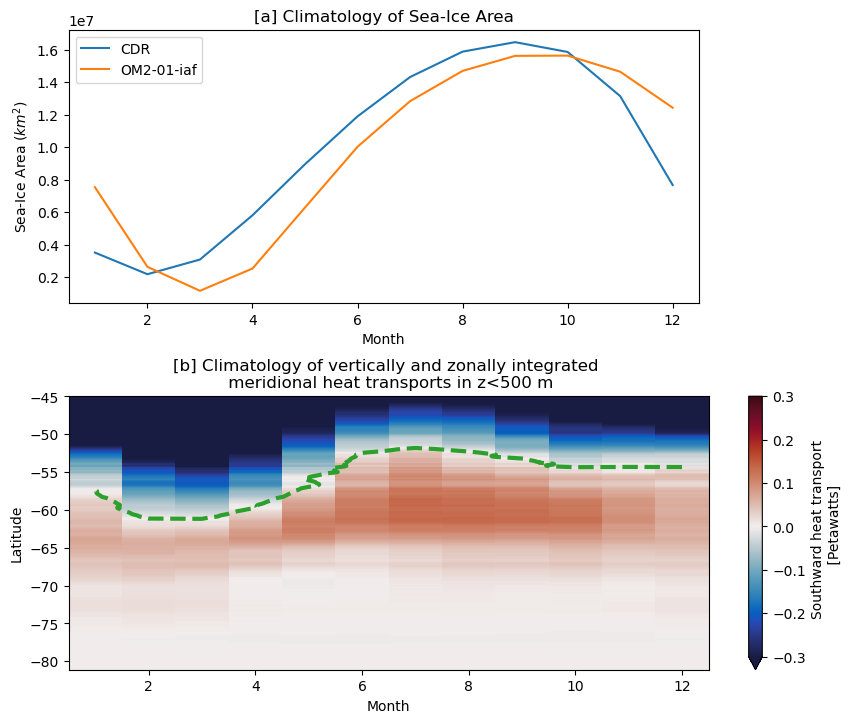

In [178]:
fig = plt.figure(figsize=(10,8))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.34)
gs = gridspec.GridSpec(2, 5, height_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, 0:4])
climatology(obs_area_dt["cdr_sh"].ds.cdr_area).plot(label="CDR")
climatology(1e-6*SIA).plot(label="OM2-01-iaf")
plt.title("[a] Climatology of Sea-Ice Area")
plt.ylabel("Sea-Ice Area ($km^2$)")
plt.xlabel('Month')
plt.xlim(0.5,12.5)
plt.legend()


ax2 = fig.add_subplot(gs[1, :])
(-1e-15*Tyfull_clim_y_z500).plot(y='yu_ocean',vmin=-.3,vmax=.3,cmap=cm.balance,cbar_kwargs={'label': "Southward heat transport \n [Petawatts]"})
(-1e-15*Tyfull_clim_y_z500.sel(yu_ocean=slice(-65,-45))).plot.contour(y='yu_ocean',levels=[0,],linewidths=3,linestyles='--',colors='tab:green')
plt.ylabel('Latitude')
plt.xlabel('Month')
plt.title("[b] Climatology of vertically and zonally integrated \n meridional heat transports in z<500 m")


plt.savefig(figdir + 'Upper_layers_depth_seasonality.png',dpi=300)

At the surface, the ehat transport appears to have some itneresting seasonal cycle. Specifically, we see that during low sea ice months the MHT reaches 10 degrees further south, when compared to the high sea ice months

**Next steps:** Look up at the EKE distribution, and how much of these heat transport changes are driven by Eddies (by decomposing Eddy heat transport and mean)